<h1><center>Programming Exercise 7:<br>K-means Clustering and Principal Component Analysis</center></h1>

In [127]:
from scipy.io import loadmat
from scipy.misc import imread 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from sklearn import preprocessing
from numpy.linalg import svd
from scipy.misc import toimage
from mpl_toolkits.mplot3d import Axes3D 

mpl.rcParams['figure.figsize'] = (10,6)

# 1. K-means Clustering
- Implement the K-means algorithm and use it for image compression. First start on an example 2D dataset to gain an intuition of how the algorithm works
- Afterwards, use K-means for image compression by reducing the number of colors that occur in an image to only those that are the most common in that image

## 1.1 Implementing K-means

In [2]:
data1 = loadmat('ex7data2.mat')
X = data1['X'] # no need to add the bias terms, as convention for K-means
               # there are 300 samples with 2 features each

- Initially we choose 3 centroids and initialize them as given in ex7.m:

In [3]:
K = 3 # 3 centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]]) # centroid coordinates

In [4]:
def findClosestCentroids(X,centroids):
    '''
    Computes L2 squared norm of every sample in design matrix X to each centroid in centroids
    Finds the minimum distance for every sample and returns the label to the closest centroid
    
    Parameters
    ------------
    X: m by n design matrix
    centroids: K by n centroid matrix with n-coordinates for each of the K centroids
    
    Returns
    ------------
    idx: 1D m-dimensional array with labels of closest centroid for all samples
    '''
    
    K = centroids.shape[0] # number of centroids
    m,num_feats = X.shape # number of samples and features
    norm_array = np.empty((m,K)) # initialize norm array, K L2 squared norm per sample
    
    for ii_idx,ii_centroid in enumerate(centroids): # iterate through centroids
        ii_diff_array = X-ii_centroid # compute vector distance to centroid for all samples
        norm_array[:,ii_idx] = np.linalg.norm(ii_diff_array,axis=1)**2 # compute L2 squared norms for all samples
    
    idx = np.argmin(norm_array,axis=1) # indices of min distance along 3rd axis, i.e all centroids
    
    return idx

- Find closest centroids to the first 3 samples:

In [5]:
idx = findClosestCentroids(X,initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3]+1) # + 1 because we index starting with 0 and the homework is labeing centroids starting with 1

Closest centroids for the first 3 examples:
[1 3 2]


- Now write a function to compute the mean of the centroids from all points assigned to them respectively:

In [6]:
def computeCentroids(X,idx,K):
    '''
    Computes new centroids by averaging over all samples assigned to clusters
    
    Parameters
    ------------
    X: m by n design matrix
    idx: 1D m-dimensional array with labels of closest centroid for all samples
    K: number of clusters
    
    Returns
    ------------
    new_centroids: K by n matrix of new centroids
    '''
    
    new_centroids = np.empty((K,X.shape[1])) # allocate space for new centroids
    
    for ii_centroid in range(K): # loop through centroids
        ii_centroid_cut = [idx==ii_centroid] # cut for samples assigned to centroid
        ii_X = X[ii_centroid_cut] # design matrix of all samples assigned to centroid
        ii_avg_centroid = np.average(ii_X,axis=0) # average of features (along columns) for this centroid's design matrix
        new_centroids[ii_centroid,:] = ii_avg_centroid # save centroid
    
    return new_centroids

- Compute means based on the closest centroids found in the previous part:

In [7]:
centroids = computeCentroids(X,idx,K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)

Centroids computed after initial finding of closest centroids:
[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]


## 1.2 K-means on Example Dataset
- Run K-means on a toy 2D dataset
- Define the algorithm:

In [8]:
def runkMeans(X,initial_centroids,max_iters):
    '''
    Runs K-Means algorithm on data in design matrix X for max_iters iterations
    
    Parameters
    ------------
    X: m by n design matrix
    initial_centroids: K by n centroid matrix with n-coordinates for each of the K initial centroids
    max_iters: number of iterations for K-Means algorithm
    
    Returns
    ------------
    centroids: 3D array of K by n by max_iters+1 dimensions. One 2D array of centroids for each iteration
    idx: 1D m-dimensional array with labels of closest centroid for all samples
    '''
    
    K = initial_centroids.shape[0] # number of centroids
    m,num_feats = X.shape # number of samples and features
    centroids = np.empty((K,num_feats,max_iters+1)) # centroid history 3D array
                                                    # one 2D array per iteration, +1 because we include the initial guess
    centroids[:,:,0] = initial_centroids # save initial centroid guess
        
    for ii_iter in range(max_iters): # K-Means iteration
        idx = findClosestCentroids(X,centroids[:,:,ii_iter])
        centroids[:,:,ii_iter+1] = computeCentroids(X,idx,K)
        
    return centroids,idx

In [9]:
max_iters = 10
centroids, idx = runkMeans(X,initial_centroids,max_iters)

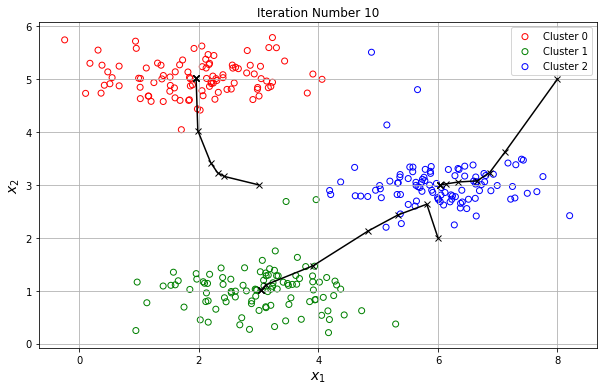

In [10]:
plt.figure()
plt.grid()
plt.scatter(X[:,0][idx==0],X[:,1][idx==0],marker='o',edgecolors='r',facecolors='none',label='Cluster 0')
plt.scatter(X[:,0][idx==1],X[:,1][idx==1],marker='o',edgecolors='g',facecolors='none',label='Cluster 1')
plt.scatter(X[:,0][idx==2],X[:,1][idx==2],marker='o',edgecolors='b',facecolors='none',label='Cluster 2')
plt.plot(centroids[0,0,:],centroids[0,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[1,0,:],centroids[1,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[2,0,:],centroids[2,1,:],linestyle='-',marker='x',color='k')
plt.legend()
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title('Iteration Number {}'.format(max_iters))
plt.show()

## 1.3 Random Initialization
- Implement a function to randomly initialize centroids for K-Means algorithm
- A good strategy for initializing the centroids is to select them as random samples from the training set. The procedure:
    - Randomly permute the indices of the samples
    - Then select K samples 

In [11]:
def kMeansInitCentroids(X,K):
    '''
    Initializes centroids by randomly choosing K samples from design matrix X
    
    Parameters
    ------------
    X: m by n design matrix
    K: number of clusters
    
    Returns
    ------------
    initial_centroids: K by n centroid matrix with n-coordinates for each of the K initial centroids
    '''
    
    m,num_feats = X.shape # number of samples and features
    rand_ind = random.sample(range(m),K) # choose K indices at random from design matrix X
    initial_centroids = X[rand_ind] # save those random samples as initial centroids
    
    return initial_centroids

- Now let's test it by trying clustering as above but with the random initialization:

In [12]:
initial_centroids = kMeansInitCentroids(X,K)
centroids, idx = runkMeans(X,initial_centroids,max_iters)

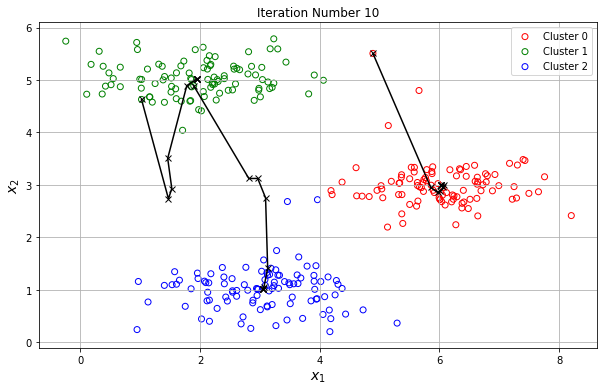

In [13]:
plt.figure()
plt.grid()
plt.scatter(X[:,0][idx==0],X[:,1][idx==0],marker='o',edgecolors='r',facecolors='none',label='Cluster 0')
plt.scatter(X[:,0][idx==1],X[:,1][idx==1],marker='o',edgecolors='g',facecolors='none',label='Cluster 1')
plt.scatter(X[:,0][idx==2],X[:,1][idx==2],marker='o',edgecolors='b',facecolors='none',label='Cluster 2')
plt.plot(centroids[0,0,:],centroids[0,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[1,0,:],centroids[1,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[2,0,:],centroids[2,1,:],linestyle='-',marker='x',color='k')
plt.legend()
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title('Iteration Number {}'.format(max_iters))
plt.show()

## 1.4 Image Compression with K-means
- Apply K-Means to image compression to a 24-bit color image
- In each of these images, a pixel is represented by three 8-bit unsigned integers (ranging from 0-255) that specify the red, green and blue intensity values; this encoding is refered to as RGB
- The sample image has thousands of colors and here we'll reduce it to only 16 colors
- We will treat every pixel in the original image as a data sample and use the K-Means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space
- Once we have computed the cluster centroids on the image, we will use the 16 colors to replce the pixels in the original image

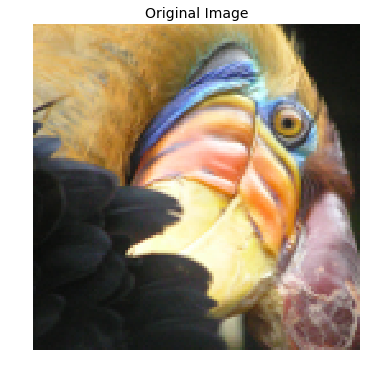

In [14]:
A = imread('bird_small.png') # load bird image
og_imshape = A.shape
# Shape is (128,128,3) makes sense since the image is 128x128 pixels RGB

# Show the original image
plt.figure()
plt.imshow(A) 
plt.axis('off')
plt.title('Original Image',fontsize=14)
plt.show()

A = A/255 # Divide by 255 so that all values are in the range 0-1

A = np.reshape(A,(A.shape[0]*A.shape[1],3)) # reshape into design matrix
                                            # shape will be (128*128=)16384 by 3

In [15]:
K = 16 # we want 16 clusters for compression
max_iters = 10 

initial_centroids = kMeansInitCentroids(A,K) # get random initial centroids from samples

centroids,idx = runkMeans(A,initial_centroids,max_iters) # run K-Means

- Now recover the image from the indices (idx) by mapping each pixel (specified by its index in idx) to the centroid value:

In [16]:
X_recovered = centroids[:,:,-1][idx] # each sample (pixel) has been assigned to a cluster, labeled in idx
                                     # let's represent each sample by the centroid is has been assigned to
X_recovered = np.reshape(X_recovered,(og_imshape[0],og_imshape[1],3)) # reshape into orignal image shape

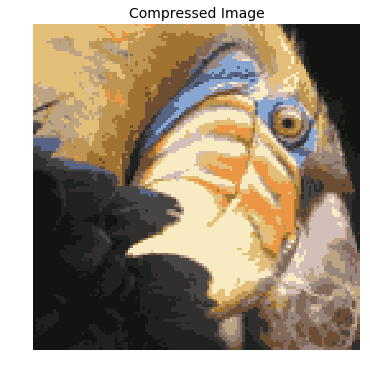

In [17]:
# Show compressed image
plt.figure()
plt.imshow(X_recovered) 
plt.axis('off')
plt.title('Compressed Image',fontsize=14)
plt.show()

- Note that the original image required 24 bits for each one of the 128 by 128 pixel locations so in total $128\times128\times24=393,216$ bits
- The new representation requires some overhead storage in the form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel so in total $16\times24+128\times128\times4=65,920$ bits thus we have compressed the image by about a factor of 6

## 1.5 Optional Exercise: Use Your Image
- Run K-Means on "my own" image
- I'll choose Pollock's Circumcision since it has a myriad of colors...and it's also on of my favourite paintings
- Let's try a smaller number of clusters (colors) than 16, how about 7?

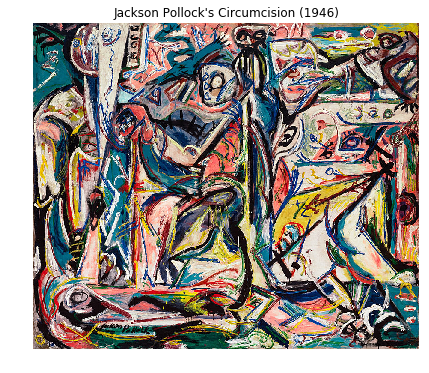

In [18]:
A = imread('pollock_circumcision.jpg') # load bird image
og_imshape = A.shape # shape is (763, 902, 3)

# Show the original image
plt.figure()
plt.imshow(A) 
plt.axis('off')
plt.title("Jackson Pollock's Circumcision (1946)",fontsize=12)
plt.show()

A = A/255 # Divide by 255 so that all values are in the range 0-1

A = np.reshape(A,(A.shape[0]*A.shape[1],3)) # reshape into design matrix
                                            # shape will be (128*128=)16384 by 3

In [19]:
K = 7 # we want 16 clusters for compression
max_iters = 10 

initial_centroids = kMeansInitCentroids(A,K) # get random initial centroids from samples

centroids,idx = runkMeans(A,initial_centroids,max_iters) # run K-Means

In [20]:
X_recovered = centroids[:,:,-1][idx] # each sample (pixel) has been assigned to a cluster, labeled in idx
                                     # let's represent each sample by the centroid is has been assigned to
X_recovered = np.reshape(X_recovered,(og_imshape[0],og_imshape[1],3)) # reshape into orignal image shape

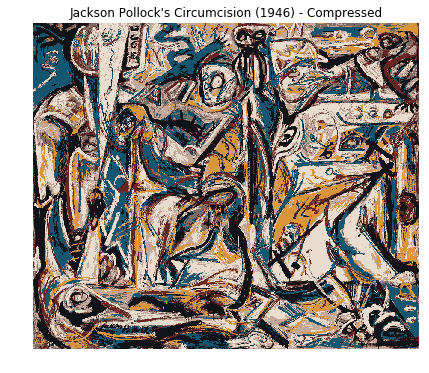

In [21]:
# Show compressed image
plt.figure()
plt.imshow(X_recovered) 
plt.axis('off')
plt.title("Jackson Pollock's Circumcision (1946) - Compressed",fontsize=12)
plt.show()

- it's fair to say that if the artist had access only to 10 colors the piece would be heavily muted but still a masterpiece

# 2. Principal Component Analysis
- Use PCA to perform dimensionality reduction
- First experiment with an example 2D dataset to get intuition on how PCA works and then use it on a bigger dataset of 5000 face images 

## 2.1 Example Dataset
- This 2D dataset has one direction of large variation and one of smaller variation. Here we will visualize what happens when we use PCA to reduce the data from 2D to 1D

In [50]:
data2 = loadmat('ex7data1.mat') # load data
X = data2['X'] # load design matrix; again no need to add bias term

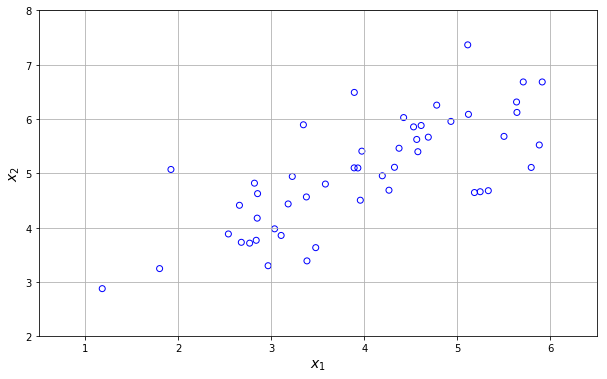

In [51]:
plt.figure()
plt.grid()
plt.scatter(X[:,0],X[:,1],marker='o',edgecolors='b',facecolors='none')
plt.xlim(0.5,6.5)
plt.ylim(2,8)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.show()

## 2.2 Implementing PCA
- First mean normalize (scale) data:

In [52]:
scaler = preprocessing.StandardScaler().fit(X) # instantiate scaler
scale_mean = scaler.mean_ # mean of features
scale_std = scaler.var_ # variance of features
X_scaled = scaler.transform(X) # scale data and overwrite

- Now implement a PCA function that:
    1. Computes the covariance matrix $\Sigma=(1/m)X^T\cdot X$ (regular matrix multiplication)
    2. Run singular-value-decomposition, i.e $\Sigma=U\cdot S\cdot V^*$, to compute the principal components and save the $U$ and $S$ matrices; $U$ will contain the (left-singular) eigenvectors as rows and $S$ will contain the singular values 

In [53]:
def pca(X):
    '''
    Computes the covariance of the design matrix and finds its eigenvectors and eigenvalues
    
    Parameters
    ------------
    X: m by n design matrix
    
    Returns
    ------------
    U: m by m array of (left-singular) eigenvectors of covariance matrix, each row is an eigenvector
    S: 1D array of length m with singular values (eigenvalues) of covariance matrix
    '''    
    m = X.shape[0]
    cov_matrix = (1/m)*X.T @ X
    U,S,_ = svd(cov_matrix) # the returned s is a 1D array of eigenvalues
    return U,S

In [54]:
U,S = pca(X_scaled) # u is of shape 2 by 2 here
             # s is a length 2 array
    
print('Top eigenvector is: {}'.format(U[0,:]))

Top eigenvector is: [-0.70710678 -0.70710678]


- Draw the eigenvectors centered at mean of data. These lines show the diractions of maximum variations in the dataset:

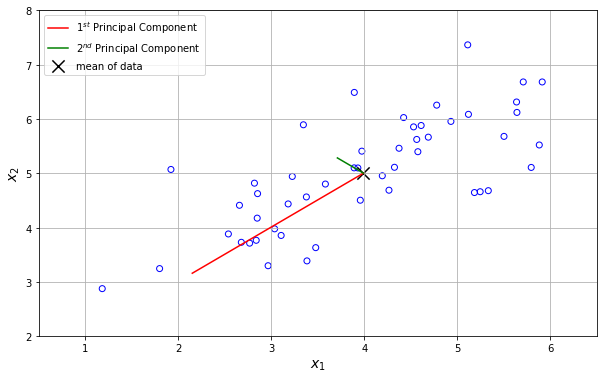

In [55]:
plt.figure()
plt.grid()
plt.scatter(X[:,0],X[:,1],marker='o',edgecolors='b',facecolors='none')
plt.scatter(scale_mean[0],scale_mean[1],marker='x',c='k',s=150,label='mean of data') # mean of data
plt.plot([scale_mean[0], scale_mean[0] + 1.5*S[0]*U[0,0]], 
         [scale_mean[1],scale_mean[1] + 1.5*S[0]*U[0,1]],
         '-r',label=r'$1^{st}$ Principal Component')
plt.plot([scale_mean[0], scale_mean[0] + 1.5*S[1]*U[1,0]], 
         [scale_mean[1],scale_mean[1] + 1.5*S[1]*U[1,1]],
         '-g',label=r'$2^{nd}$ Principal Component')
plt.xlim(0.5,6.5)
plt.ylim(2,8)
plt.legend(loc='upper left')
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.show()

## 2.3 Dimensionality Reduction with PCA
- Now that we have the principal components we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space where for each sample we would do:

$$
z^{i}=U^T_\text{reduced}\cdot x^{i}
$$

or for all samples using the design matrix:

$$
Z = X\cdot U^T_\text{reduced}
$$

with $U_\text{reduced}$ the matrix holding $K$ eigenvectors $K\leq n$. The new design matrix $Z$ will be of shape $m\times K$ since $X$ is of shape $m\times n$ and $U_\text{reduced}$ is of shape $K\times n$.

In [56]:
def projectData(X,U,K):
    '''
    Projects the data onto the subspace spanned by the design's matrix first K covariance eigenvector
    
    Parameters
    ------------
    X: m by n design matrix
    U: m by m array of (left-singular) eigenvectors of covariance matrix
    K: number of principal components to use for projection; the first K will be chosen

    Returns
    ------------
    Z: m by k array, transformed design matrix
    '''   
    U_reduced = U[:K,:] # only first K eigenvectors (rows)
    Z = X @ U_reduced.T # project data onto K eigenvectors
    
    return Z

In [57]:
K = 1 # project to 1D
Z = projectData(X_scaled,U,K)

print('Projection of the first sample: {}'.format(Z[0]))

Projection of the first sample: [ 1.49631261]


- After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space
- Note that to approximate the samples from the transformed design matrix we need:

$$
X_\text{approx} = Z\cdot U_\text{reduced}
$$

so that $X$ is of shape $m\times n$.

In [58]:
def recoverData(Z,U,K):
    '''
    Approximates the original feature space given the subspace eigenvectors and transformed features
    
    Parameters
    ------------
    Z: m by k array, transformed design matrix
    U: m by m array of (left-singular) eigenvectors of covariance matrix
    K: number of principal components to use for projection; the first K will be chosen

    Returns
    ------------
    X_approx: m by n array of approximated samples from original feature space
    '''     
    U_reduced = U[:K,:] # only first K eigenvectors (rows)
    X_approx = Z @ U_reduced
    
    return X_approx

In [59]:
X_approx = recoverData(Z,U,K)

print('Approximateion of the first sample: {}'.format(X_approx[0,:]))

Approximateion of the first sample: [-1.05805279 -1.05805279]


- Draw lines connecting the projected points to the original (scaled) points:

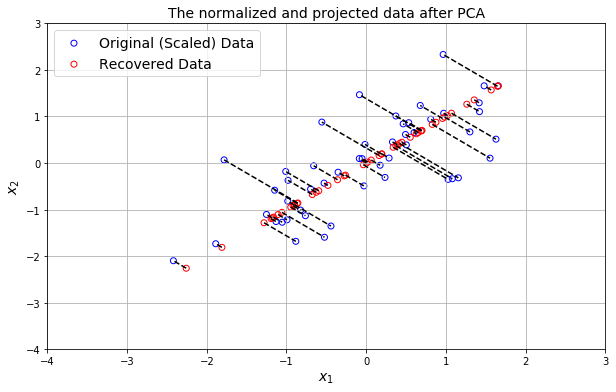

In [60]:
plt.figure()
plt.grid()
plt.scatter(X_scaled[:,0],X_scaled[:,1],marker='o',edgecolors='b',facecolors='none',label='Original (Scaled) Data')
plt.scatter(X_approx[:,0],X_approx[:,1],marker='o',edgecolors='r',facecolors='none',label='Recovered Data')
for ii_idx in range(X_scaled.shape[0]):
    ii_scaled = X_scaled[ii_idx]
    ii_approx = X_approx[ii_idx]
    plt.plot([ii_approx[0],ii_scaled[0]],[ii_approx[1],ii_scaled[1]],linestyle='--',c='k')
plt.legend(loc='upper left',fontsize=14)
plt.xlim(-4,3)
plt.ylim(-4,3)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title('The normalized and projected data after PCA',fontsize=14)
plt.show()

- As we can see, the projection only effectively retains the information in the direction given by the first eigenvector

## 2.4 Face Image Dataset
- Now run PCA on face images to see how it can be used in practice for dimension reduction
- The dataset `ex7faces.mat` contains a dataset $X$ of 5000 face images, each a $32\times32$ in grayscale. Each row of $X$ corresponds to one face image (a row vector of length 1024)

In [61]:
data3 = loadmat('ex7faces.mat')
X = data3['X'] # shape is 5000 by 1024

- Visualize the first 100 of these face images:
    - Just like in ex3.ipynb we need to flip and rotate the images to get them as in the homework pdf

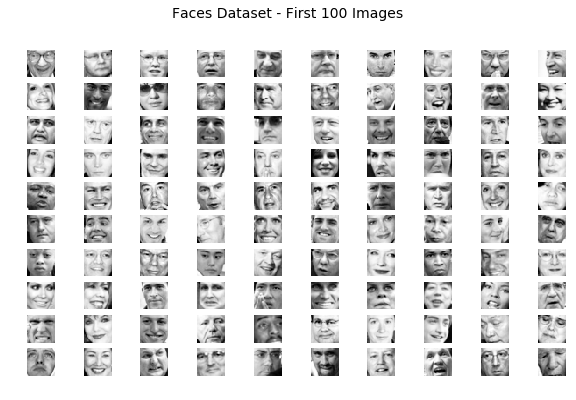

In [34]:
plt.figure()
for ii_idx in range(100):
    ii_sample = X[ii_idx,:]
    ii_sample = np.reshape(ii_sample,(32,32)) # reshape into 32 by 32 image
    ii_sample = np.flipud(ii_sample) # flip upside-down
    ii_image = toimage(ii_sample) # make grayscale image
    ii_image = ii_image.rotate(270) # rotate by 270 degrees
    plt.subplot(10,10,ii_idx+1) # show image
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle('Faces Dataset - First 100 Images',fontsize=14)
plt.show()

- Mean normalize (scale) dataset:

In [62]:
scaler = preprocessing.StandardScaler().fit(X) 
scale_mean = scaler.mean_ 
scale_std = scaler.var_ 
X_scaled = scaler.transform(X)

- Run PCA:

In [81]:
U,S = pca(X_scaled)

- Visualize the top 36 components found:

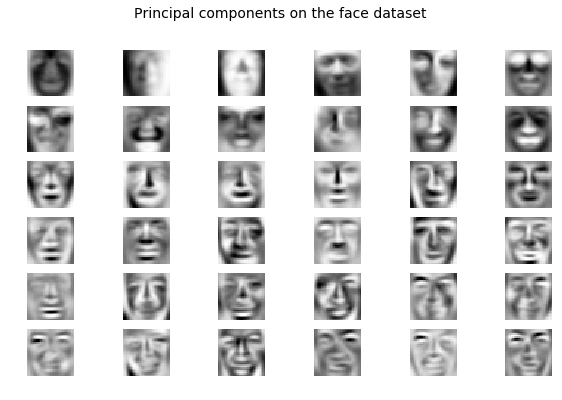

In [71]:
plt.figure()
for ii_idx,ii_sample in enumerate(U[:,:36].T): 
    ii_sample = np.reshape(ii_sample,(32,32)) # reshape into 32 by 32 image
    ii_sample = np.flipud(ii_sample) # flip upside-down
    ii_image = toimage(ii_sample) # make grayscale image
    ii_image = ii_image.rotate(270) # rotate by 270 degrees
    plt.subplot(6,6,ii_idx+1) # show image
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle('Principal components on the face dataset',fontsize=14)
plt.show()

- best eigenvectors I've ever seen
- Now project the face dataset onto only the first 1000 principal components. Concretely, each face image is now described by a vector $z^{(i)}\in \mathbb{R}^{1000}$

In [120]:
K = 1000
Z = projectData(X_scaled,U,K)

print('The projected data Z has a size of: {}'.format(Z.shape))

The projected data Z has a size of: (5000, 1000)


- Recover data:

In [121]:
X_approx = recoverData(Z,U,K) # recover data

- Display 100 original (scaled) images:

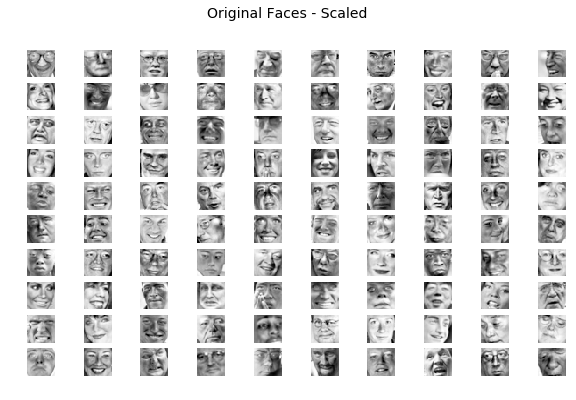

In [96]:
plt.figure()
for ii_idx in range(100):
    ii_sample = X_scaled[ii_idx,:]
    ii_sample = np.reshape(ii_sample,(32,32)) # reshape into 32 by 32 image
    ii_sample = np.flipud(ii_sample) # flip upside-down
    ii_image = toimage(ii_sample) # make grayscale image
    ii_image = ii_image.rotate(270) # rotate by 270 degrees
    plt.subplot(10,10,ii_idx+1) # show image
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle('Original Faces - Scaled',fontsize=14)
plt.show()

- all these faces are styling the Donald Trump eyes pretty bad
- Now display reconstructed data:

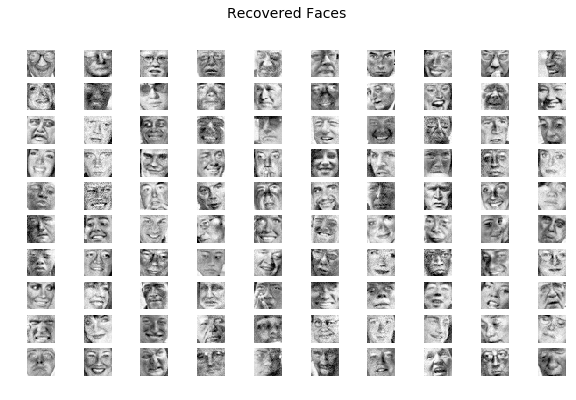

In [122]:
plt.figure()
#for ii_idx,ii_sample in enumerate(X_approx[:100,:].T):
for ii_idx in range(100):
    ii_sample = X_approx[ii_idx,:]
    ii_sample = np.reshape(ii_sample,(32,32)) # reshape into 32 by 32 image
    ii_sample = np.flipud(ii_sample) # flip upside-down
    ii_image = toimage(ii_sample) # make grayscale image
    ii_image = ii_image.rotate(270) # rotate by 270 degrees
    plt.subplot(10,10,ii_idx+1) # show image
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle('Recovered Faces',fontsize=14)
plt.show()

- We see that the general structure and appearance of the face are kept while the fine details are lost. This is a remarkable reduction in dataset size that can help speed up your learning algorithm significantly

## 2.5 Optional Exercise: PCA for Visualization 
- Earlier we used K-Means in the 3D RGB space. We will first work on visualizing the final pixel assignments in this 3D space with each data point colored according to the cluster is has been assigned to
- First redo the K-Means on the bird image from above:

In [123]:
A = imread('bird_small.png') # load the bird
A = A/255 # Divide by 255 so that all values are in the range 0-1
A = np.reshape(A,(A.shape[0]*A.shape[1],3)) # reshape into design matrix
                                            # shape will be (128*128=)16384 by 3
K = 16 # we want 16 clusters for compression
max_iters = 10 

initial_centroids = kMeansInitCentroids(A,K) # get random initial centroids from samples

centroids,idx = runkMeans(A,initial_centroids,max_iters) # run K-Means

- Sample 1000 random indices only:

In [176]:
rand_ind = random.sample(range(A.shape[0]),1000)
rand_idx = idx[rand_ind]
rand_A = A[rand_ind,:]

- Display 1000 points and their cluster assigment (different colors):

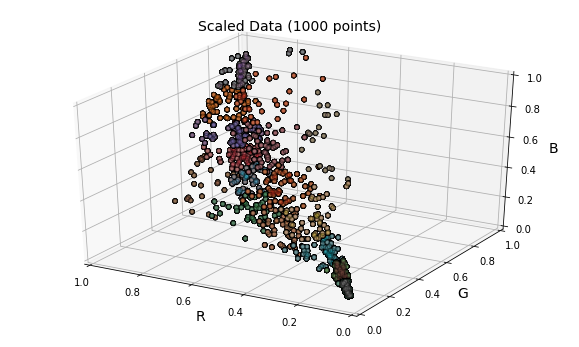

In [198]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for ii_ind in rand_idx:
    ii_cut = [rand_idx==ii_ind][0]
    ax.scatter(rand_A[:,0][ii_cut], rand_A[:,1][ii_cut], rand_A[:,2][ii_cut], edgecolors='k',alpha=0.25)
plt.xlabel('R',fontsize=14)
plt.ylabel('G',fontsize=14)
ax.set_zlabel('B',fontsize=14)
ax.set_zlim(0,1)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.invert_xaxis()
plt.title('Scaled Data (1000 points)',fontsize=14)
plt.show()

- Now we apply PCA to this 3D data to reduce it to 2D and visualize the result in a 2D scatter plot 

In [189]:
# Feature scale
scaler = preprocessing.StandardScaler().fit(A) 
scale_mean = scaler.mean_ 
scale_std = scaler.var_ 
A_scaled = scaler.transform(A)

# PCA
U,S = pca(A_scaled)
Z = projectData(A_scaled,U,2)

# Pick the 1000 random points above
rand_Z = Z[rand_ind,:]

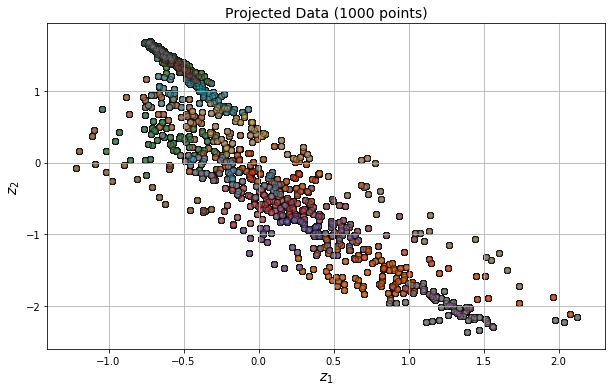

In [199]:
plt.figure()
plt.grid()
for ii_ind in rand_idx:
    ii_cut = [rand_idx==ii_ind][0]
    plt.scatter(rand_Z[:,0][ii_cut], rand_Z[:,1][ii_cut],edgecolors='k',alpha=0.25)
plt.xlabel(r'$z_1$',fontsize=14)
plt.ylabel(r'$z_2$',fontsize=14)
plt.title('Projected Data (1000 points)',fontsize=14)
plt.show()

- The PCA projection can be thought of as a rotation that selects the view that maximized the spread of the data, which often corresponds to the "best" view